# Modeling the Olfactory Bulb and its Neural Oscillatory Processings
### (1989: Li & Hopfield.)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Model

### Initial Parameters

In [2]:
# ideally M:N = 200:1
N = 10 # excitatory mitral
M = 10 # inhibitory granule

t_total = 600
tau_exhale = 33

p_prob = 1
cycles = 1

### Inputs

1 2.0


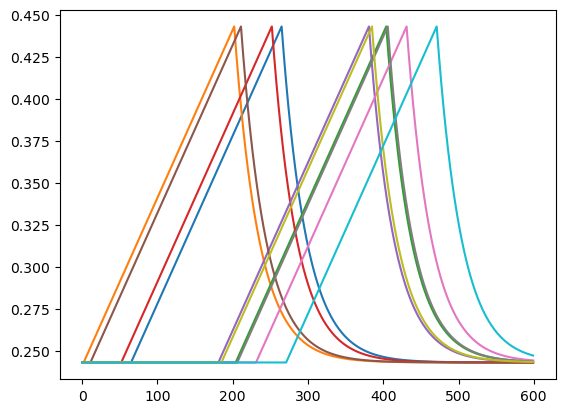

In [50]:
# background input
I_bg = 0.243 # make random
t_inhales = np.floor(np.random.uniform(low=0, high=300, size=10))
min_i = np.argmin(t_inhales)
    
def generate_m_input(p):
    P = np.random.binomial(1, p_prob, N)

    # mitral cell inputs
    I_odor = np.zeros((cycles * t_total, N))  # t x N
    for c in range(cycles):
        for i in range(N):
            P_odor = P[i]
            t_inhale = int(t_inhales[i])
            t_exhale = t_inhale + 200
            for j in range(t_total):
                if j >= t_inhale and j <= t_exhale:
                    # I_odor[j + t_total * c][i] = P_odor * ((0.2/t_exhale) * (j - t_inhale)) + I_odor[t_inhale][i]
                    I_odor[j + t_total * c][i] = P_odor * (j - t_inhale)/1000 + I_odor[t_inhale][i]
                if j > t_exhale:
                    I_odor[j + t_total * c][i] = I_odor[t_exhale][i] * \
                        pow(np.e, -(j-t_exhale)/tau_exhale)
    I = (p * I_odor + I_bg)
    return I

I = generate_m_input(1)
plt.plot(I)
print(min_i, t_inhales[min_i])
# granule cell inputs
def generate_ic_input(v):
    I_c = v
    return I_c


### Synaptic Connections

Generated ring connections (unif range on pseudo-dyagonal matrices)

In [406]:
H_0 = np.zeros((N, M))  # jth granule --> ith mitral
W_0 = np.zeros((M, N))  # mitral --> granule

for i in range(N):
    for j in range(M):
        H_diag = i * M / N
        W_diag = j * N / M
        if (j == H_diag):
            H_0[i, j] = np.random.uniform(low=0.3, high=0.5)
        elif (j == H_diag + 1) or (j == H_diag - 1) or (i - j == N - 1) or (j - i == M - 1): 
            H_0[i, j] = np.random.uniform(low=0.5, high=1.)

        if (i == W_diag):
            W_0[j, i] = np.random.uniform(low=0.3, high=0.5)
        elif (i == W_diag + 1) or (i == W_diag - 1) or (i - j == N - 1) or (j - i == M - 1) or (j > i and np.random.uniform() < 0.1):
            W_0[j, i] = np.random.uniform(low=0.5, high=1.)

df = pd.DataFrame(W_0)
df.to_csv('out_li.csv', index=False)

Sample matrices given for N = 10, M = 10

In [407]:
H_0 = np.array([[0.3, 0.9, 0, 0, 0, 0, 0, 0, 0, 0.7], \
                     [0.9, 0.4, 1, 0, 0, 0, 0, 0, 0, 0], \
                     [0, 0.8, 0.3, 0.8, 0, 0, 0, 0, 0, 0], \
                     [0, 0, 0.7, 0.5, 0.9, 0, 0, 0, 0, 0], \
                     [0, 0, 0, 0.8, 0.3, 0.8, 0, 0, 0, 0], \
                     [0, 0, 0, 0, 0.7, 0.3, 0.9, 0, 0, 0], \
                     [0, 0, 0, 0, 0, 0.7, 0.4, 0.9, 0, 0], \
                     [0, 0, 0, 0, 0, 0, 0.5, 0.5, 0.7, 0], \
                     [0, 0, 0, 0, 0, 0, 0, 0.9, 0.3, 0.9], \
                     [0.9, 0, 0, 0, 0, 0, 0, 0, 0.8, 0.3]])

W_0 = np.array([[0.3, 0.7, 0, 0, 0, 0, 0, 0, 0.5, 0.3],
                     [0.3, 0.2, 0.5, 0, 0, 0, 0, 0, 0, 0.7], 
                     [0, 0.1, 0.3, 0.5, 0, 0, 0, 0, 0, 0], 
                     [0, 0.5, 0.2, 0.2, 0.5, 0, 0, 0, 0, 0], 
                     [0.5, 0, 0, 0.5, 0.1, 0.9, 0, 0, 0, 0], 
                     [0, 0, 0, 0, 0.3, 0.3, 0.5, 0.4, 0, 0], 
                     [0, 0, 0, 0.6, 0, 0.2, 0.3, 0.5, 0, 0], 
                     [0, 0, 0, 0, 0, 0, 0.5, 0.3, 0.5, 0], 
                     [0, 0, 0, 0, 0, 0.2, 0, 0.2, 0.3, 0.7], 
                     [0.7, 0, 0, 0, 0, 0, 0, 0.2, 0.3, 0.5]])


Unif random connections

In [5]:
H_0 = np.random.uniform(size=(N, M)) * 2
W_0 = np.random.uniform(size=(M, N)) * 2

### Internal State Cell Models

Output functions

In [6]:
th = 1
Sx, Sx_prime = 1.4, 0.14
Sy, Sy_prime = 2.9, 0.29

def G_x(v):
    out = np.array([Sx_prime + Sx_prime *
                    np.tanh((x-th)/Sx_prime) if x < th else Sx_prime + Sx*np.tanh((x-th)/Sx) for x in v])
    return out

def G_y(v):
    out =  np.array([Sy_prime + Sy_prime *
                     np.tanh((y-th)/Sy_prime) if y < th else Sy_prime + Sy*np.tanh((y-th)/Sy) for y in v])
    return out

Bulb models

In [11]:
tau_x, tau_y = 7, 7
alpha_x, alpha_y = 1/tau_x, 1/tau_y

def generate_xy(p, v):
    X = np.zeros((cycles * t_total, N)) # mitral cell internal states
    Y = np.zeros((cycles * t_total, M))  # granule cell internal state

    # internal states
    X_out = np.zeros((cycles * t_total, N)) # mitral cell output states
    Y_out = np.zeros((cycles * t_total, M))  # granule cell output state

    I = generate_m_input(p)
    I_c = generate_ic_input(v)
    for t in range(cycles * t_total):
        # mitral
        y_out = G_y(Y[t-1, :])
        Y_out[t, :] = y_out
        X_dot = -H_0@y_out - alpha_x*X[t-1, :] + I[t]
        X[t, :] = X[t-1, :] + X_dot
        # granule
        x_out = G_x(X[t-1, :])
        X_out[t, :] = x_out
        Y_dot = W_0@x_out - alpha_y*Y[t-1, :] + I_c
        Y[t, :] = Y[t-1, :] + Y_dot
    return X_out, Y_out


## Graphing

#### Oscillation Graphs

Text(0.5, 0.98, 'Granule Cell Output (Unsync Input)')

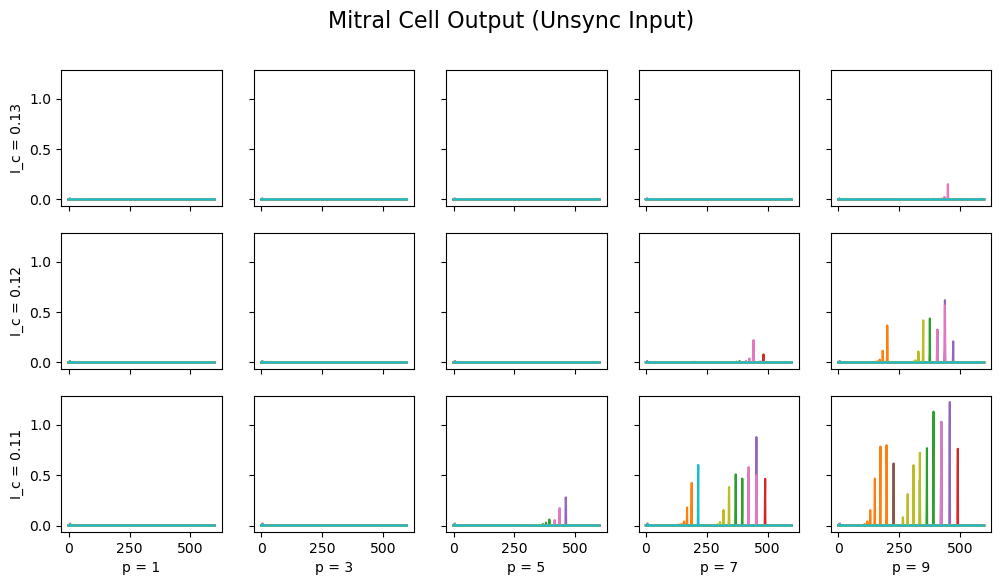

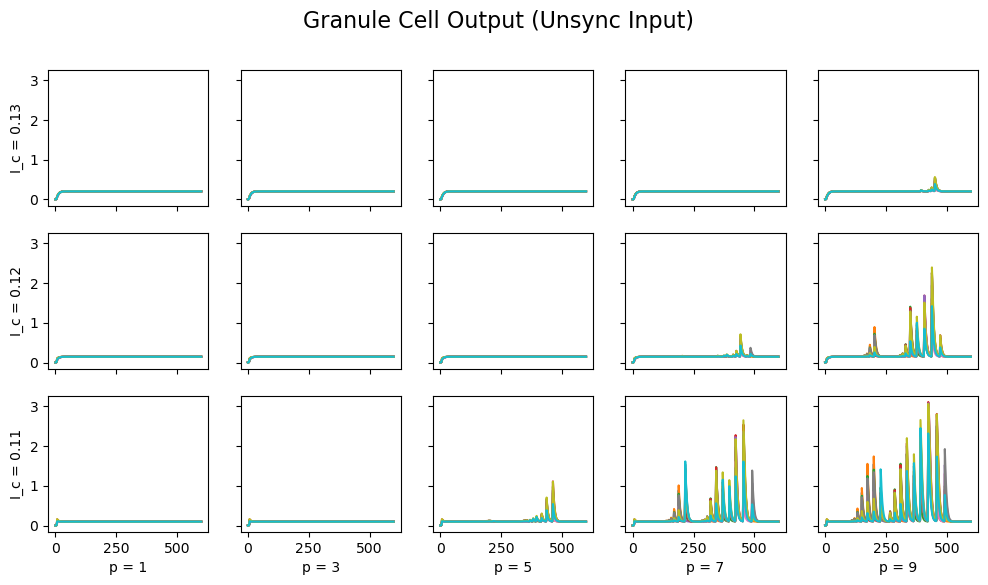

In [12]:
rows = 3
cols = 5
fig1, axs1 = plt.subplots(figsize=(12, 6), nrows=rows, ncols=cols, sharex=True, sharey=True)
fig2, axs2 = plt.subplots(figsize=(12, 6), nrows=rows, ncols=cols, sharex=True, sharey=True)
for i in range(rows):
    for j in range(cols):
        # print(f"cell : {i, j}, p = {2 * j + 1}, I_c = {0.13 - 0.01*i}")
        axs1[i, j].plot(generate_xy(2 * j + 1, 0.13 - 0.01*i)[0])
        axs2[i, j].plot(generate_xy(2 * j + 1, 0.13 - 0.01*i)[1])

for i, ax in enumerate(axs1.flat):
    ax.set(xlabel=f'p = {2*(i%5) + 1}', ylabel=f'I_c = {round(0.13 - (int(i/5))/100, 2)}')
for i, ax in enumerate(axs2.flat):
        ax.set(xlabel=f'p = {2*(i%5) + 1}', ylabel=f'I_c = {round(0.13 - (int(i/5))/100, 2)}')

for ax in axs1.flat:
    ax.label_outer()
for ax in axs2.flat:
    ax.label_outer()
fig1.suptitle('Mitral Cell Output (Unsync Input)', fontsize=16)
# fig1.savefig('M_output_delayo.png')
fig2.suptitle('Granule Cell Output (Unsync Input)', fontsize=16)
# fig2.savefig('G_output_delayo.png')

# df = pd.DataFrame(X_out, columns = [f"Cell {i+1}" for i in range(N)], index=[i for i in range(cycles * t_total)])
# df.to_csv('out_li.csv')


1


/var/folders/k0/8ymf_pwj26lfhg2zckp9zy_w0000gp/T/ipykernel_12340/2087423121.py:44: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig1.show()
/var/folders/k0/8ymf_pwj26lfhg2zckp9zy_w0000gp/T/ipykernel_12340/2087423121.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig2.show()


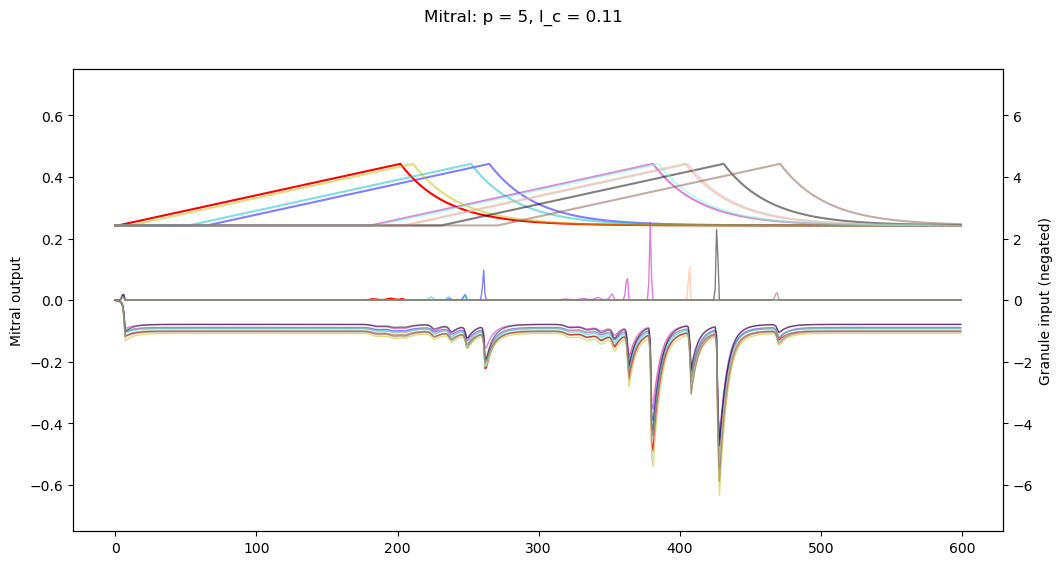

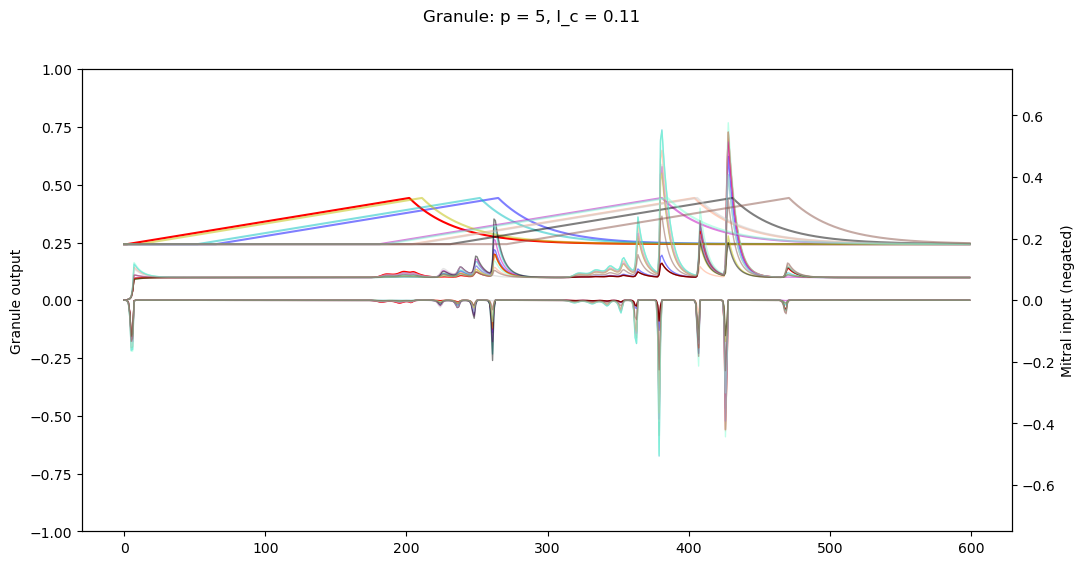

In [70]:
colors = ['b', 'g', 'lightsalmon', 'c', 'm', 'y', 'k', '0.8', 'aquamarine', 'tab:brown']

p = 5
ic = 0.11
lim_1, lim_11 = 0.75, 7.5
lim_2, lim_21 = 1, 0.75
M_plot, G_plot = generate_xy(p, ic)
G_input = -np.transpose((H_0@G_plot.T))
M_input = -np.transpose((W_0@M_plot.T))

fig1, ax1 = plt.subplots(figsize=(12, 6))
ax11 = ax1.twinx()
ax1.set_ylim([-lim_1, lim_1])
ax1.set_ylabel('Mitral output')
ax11.set_ylabel('Granule input (negated)')
ax11.set_ylim([-lim_11, lim_11])
print(min_i)

fig2, ax2 = plt.subplots(figsize=(12, 6))
ax21 = ax2.twinx()
ax2.set_ylim([-lim_2, lim_2])
ax2.set_ylabel('Granule output')
ax21.set_ylim([-lim_21, lim_21])
ax21.set_ylabel('Mitral input (negated)')

for i in range(10):
    if i == min_i:
        a = 1
        graph_color = 'r'
    else:
        a = 0.5
        graph_color = colors[i]
    ax1.plot(M_plot[:, i], graph_color, alpha=a, linewidth=1)
    ax1.plot(I[:, i], graph_color, alpha=a)
    ax11.plot(G_input[:, i], graph_color, linewidth=1, alpha=a)

    ax2.plot(G_plot[:, i], graph_color, alpha=a, linewidth=1)
    ax2.plot(I[:, i], graph_color, alpha=a)
    ax21.plot(M_input[:, i], graph_color, linewidth=1, alpha=a)
fig1.suptitle(f'Mitral: p = {p}, I_c = {ic}')
fig2.suptitle(f'Granule: p = {p}, I_c = {ic}')
fig1.savefig(f'figures/output_subplots/M_plot{p}-{ic}.png')
fig2.savefig(f'figures/output_subplots/G_plot{p}-{ic}.png')
fig1.show()
fig2.show()


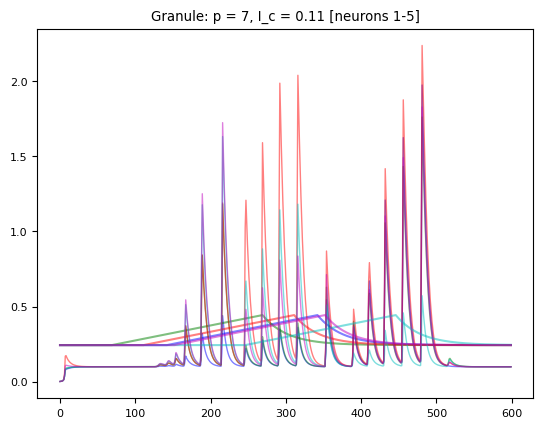

In [579]:
for i in range(5):
    plt.plot(G_plot[:, i], colors[i], alpha=a, linewidth=1)
    plt.plot(I[:, i], colors[i], alpha=a)
plt.title(f'Granule: p = {p}, I_c = {ic} [neurons 1-5]')
plt.savefig(f'G_plot{p}-{ic}.png')

#### Heatmaps

- in: output matrix of (N or M) mitral/granule cells over t timesteps
- out: averages over (N or M) cells of:
    - time oscillation start to threshold ratio 0.2
    - time oscillation decay to threshold ratio 0.2
    - maximum amplitude of oscillation
    - frequency of oscillation

In [419]:
def calculate_thresholds(Z):
    t_start, t_decay, t_max, t_freq = 0, 0, 0, 0
    tot_trials = 0
    for ind in range(Z.shape[1]):
        # find wave array, tracking max amplitude
        waves = []
        V = np.append(np.array(Z[:, ind]), 0) # take first trace for now
        V_shift = np.insert(V, 0, V[0])[:401]
        diffs = (V - V_shift)[:400]
        current_amp = 0
        max_time_amp = (-1, 0)
        for i, x in enumerate(diffs):
            if np.around(x, 3) > 0: current_amp += x
            elif current_amp != 0:
                # filter out initial spike
                if i > 50: 
                    waves.append((i, current_amp)) 
                    if current_amp > max_time_amp[1]:
                        max_time_amp = (i, current_amp)
                current_amp = 0
        
        # find values that give 0.2 ratio
        threshold = 0.2*max_time_amp[1]
        waves = [(time, amp) for (time, amp) in waves if (amp > threshold)]
        try:
            start = waves[0][0]
            decay = waves[-1][0]
        except:
            continue
        
        # print(waves)
        # keys = [key for (key, _) in waves]
        # vals = [val for (_, val) in waves]
        # plt.plot(keys, vals, 'go')
        # plt.plot([start, decay], [threshold, threshold], 'ro')
        # plt.plot(max_time_amp[0], max_time_amp[1], 'bo')
        # print(max_time_amp[0])
        
        t_start += start
        t_decay += decay
        t_max += max_time_amp[1]
        t_freq += len(waves)/.35
        tot_trials += 1
    # (start, decay, max_amp, freq)
    if tot_trials == 0:
        return (0, 0, 0, 0)
    return (t_start/tot_trials, t_decay/tot_trials, t_max, t_freq/tot_trials)



Calculation of raw heatmap values (slow step)

In [447]:
from matplotlib import cm
from matplotlib.colors import ListedColormap


p_min, p_max, p_step = 1, 9.5, 0.25
Ic_min, Ic_max, Ic_step = 0.1, 0.135, 0.0025

rows = int((Ic_max-Ic_min)/Ic_step)
cols = int((p_max-p_min)/p_step)
M_start_vals = np.zeros((rows, cols), int)
M_decay_vals = np.zeros((rows, cols), int)
M_max_vals = np.zeros((rows, cols), int)
M_freq_vals = np.zeros((rows, cols), int)

G_start_vals = np.zeros((rows, cols), int)
G_decay_vals = np.zeros((rows, cols), int)
G_max_vals = np.zeros((rows, cols), int)
G_freq_vals = np.zeros((rows, cols), int)

# print(start_vals.shape)
for i in range(rows):
    for j in range(cols):
        # print(p_min + j*p_step, Ic_max - i*Ic_step)
        Mitral, Granule = generate_xy(p_min + j*p_step, Ic_max - i*Ic_step)
        (m_start, m_decay, m_max_amp, m_freq) = calculate_thresholds(Mitral)
        (g_start, g_decay, g_max_amp, g_freq) = calculate_thresholds(Granule)
        M_start_vals[i, j] = m_start
        M_decay_vals[i, j] = m_decay
        M_max_vals[i, j] = m_max_amp
        M_freq_vals[i, j] = m_freq
        
        G_start_vals[i, j] = g_start
        G_decay_vals[i, j] = g_decay
        G_max_vals[i, j] = g_max_amp
        G_freq_vals[i, j] = g_freq


Plotting function for heatmaps

In [461]:
# HEATMAP FN
plasma_r = cm.get_cmap('plasma_r', 28)
plasma = cm.get_cmap('plasma', 28)

# arange has floating point imprecision: specify stop slightly less to avoid labeling error
xlabs = np.arange(p_min, p_max - p_step/2, p_step)
ylabs = np.flip(np.round(np.arange(Ic_min, Ic_max - Ic_step/2, Ic_step), 3))

def plot_heatmap(M, title, filename=False, reverse=True):
    cmap = plasma_r if reverse else plasma
    plt.figure(figsize=(12, 6))
    plt.rc('font', size=8)
    plt.pcolormesh(M, cmap=plasma, vmin=0.00000001)
    cmap.set_under(color='black')
    ax = plt.gca()
    ax.set_xticks(np.arange(cols)+0.5, labels=xlabs)
    ax.set_yticks(np.arange(rows)+0.5, labels=ylabs)
    plt.colorbar(extend='min')
    plt.title(title+' (Uniform 2)')
    if filename: plt.savefig('figures/uniform2/' + filename + '_2_unif')
    plt.show()


##### Main heatmaps (start and decay time)

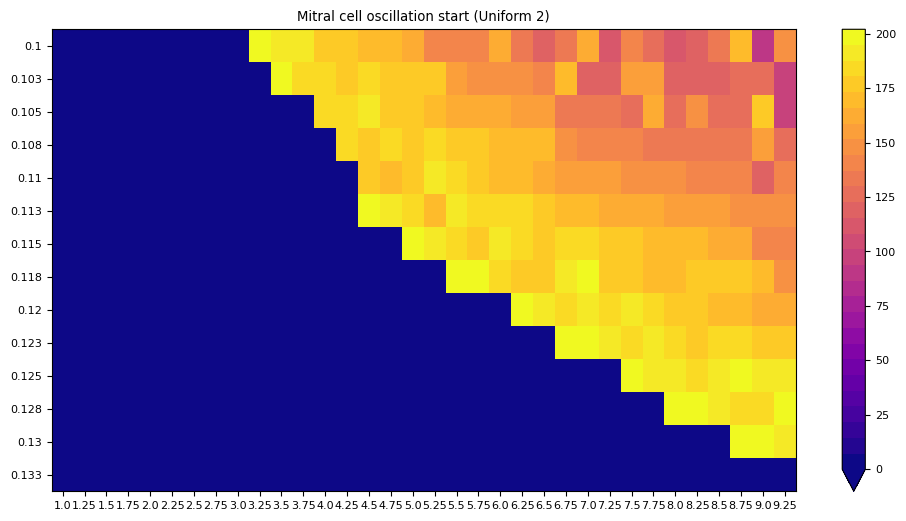

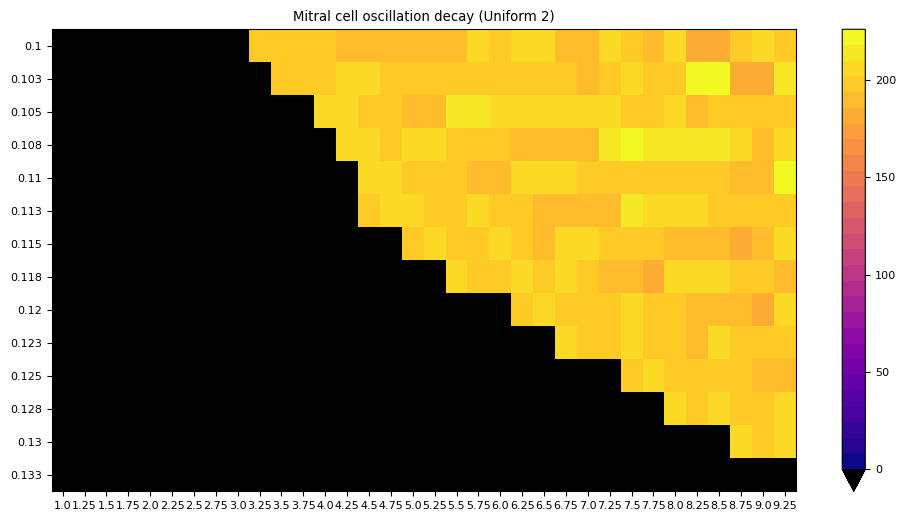

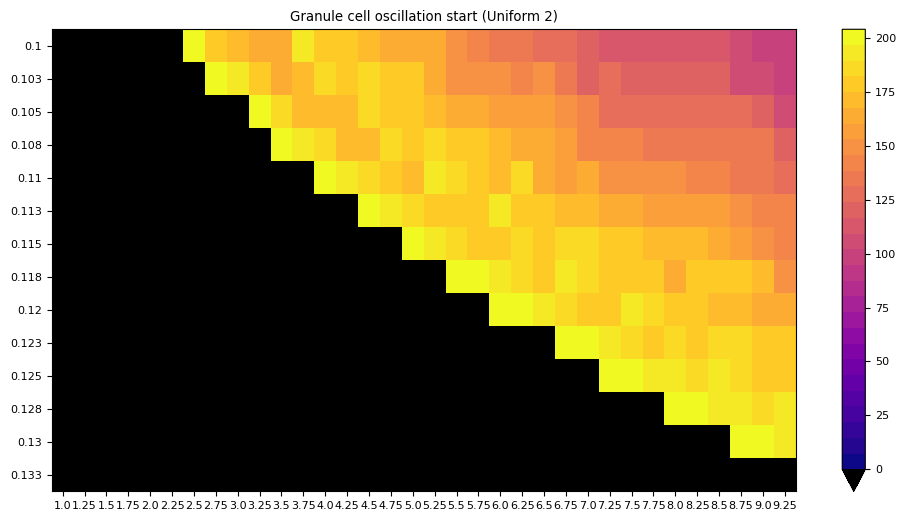

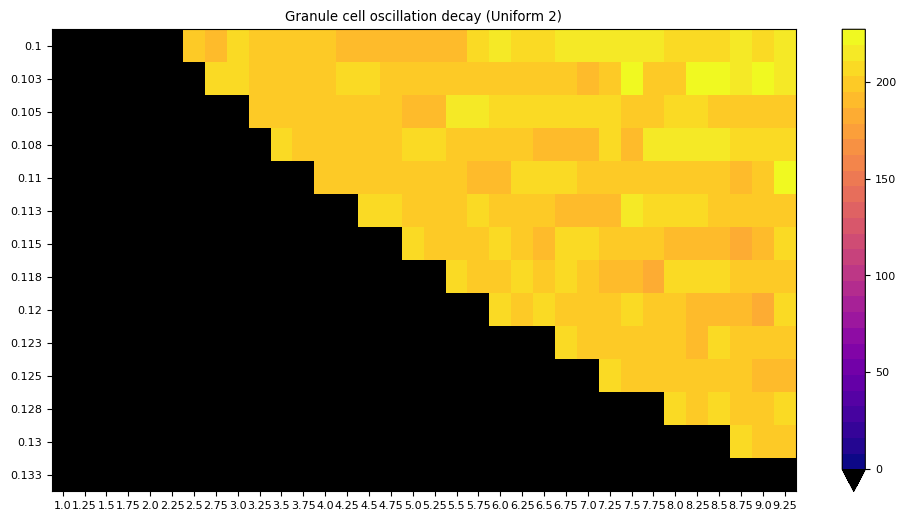

In [459]:
plot_heatmap(M_start_vals, 'Mitral cell oscillation start', 'M_start')
plot_heatmap(M_decay_vals, 'Mitral cell oscillation decay', 'M_decay', reverse=False)
plot_heatmap(G_start_vals, 'Granule cell oscillation start', 'G_start')
plot_heatmap(G_decay_vals, 'Granule cell oscillation decay', 'G_decay', reverse=False)


##### Other data heatmap (max amplitude, frequency)

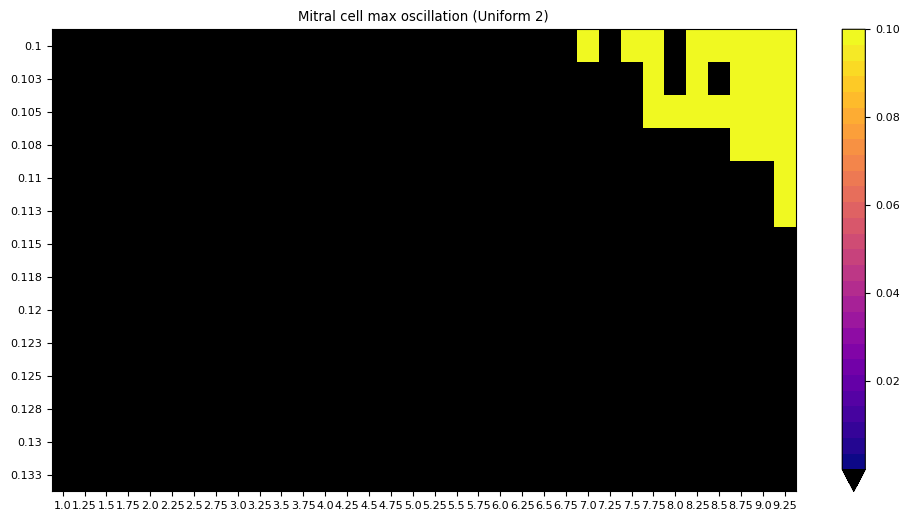

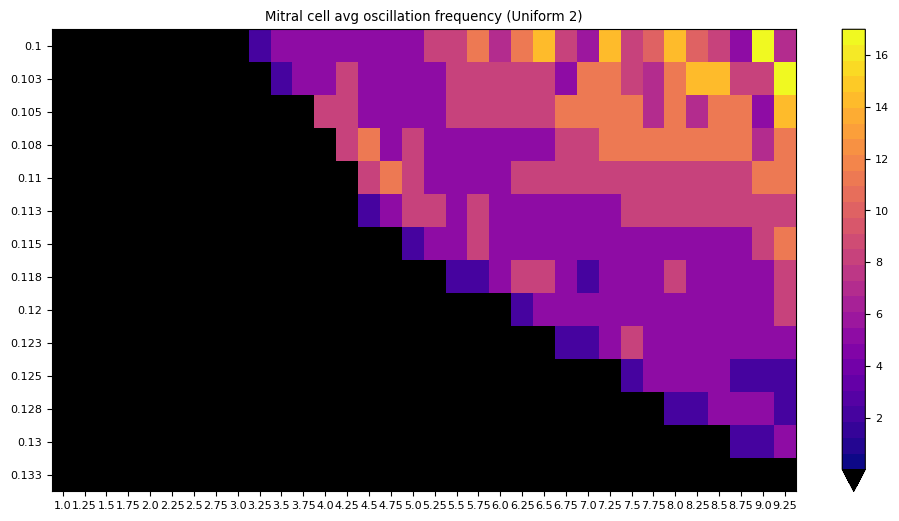

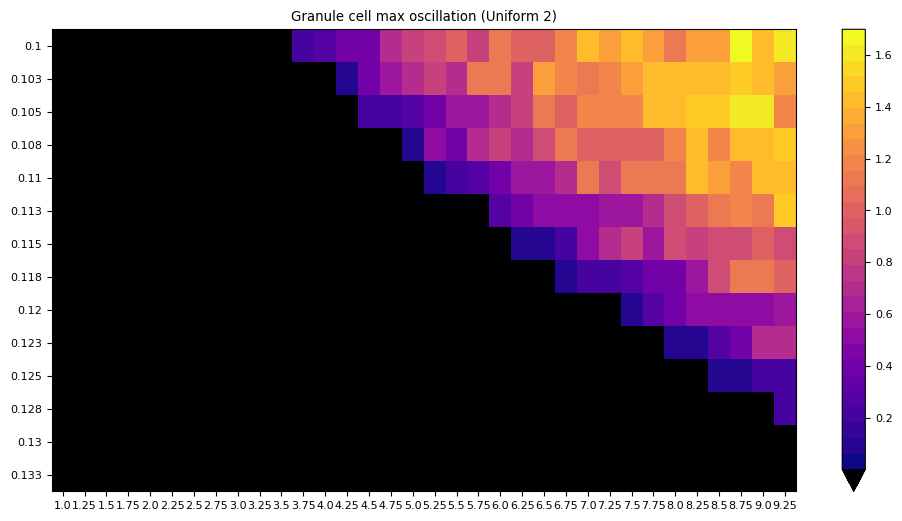

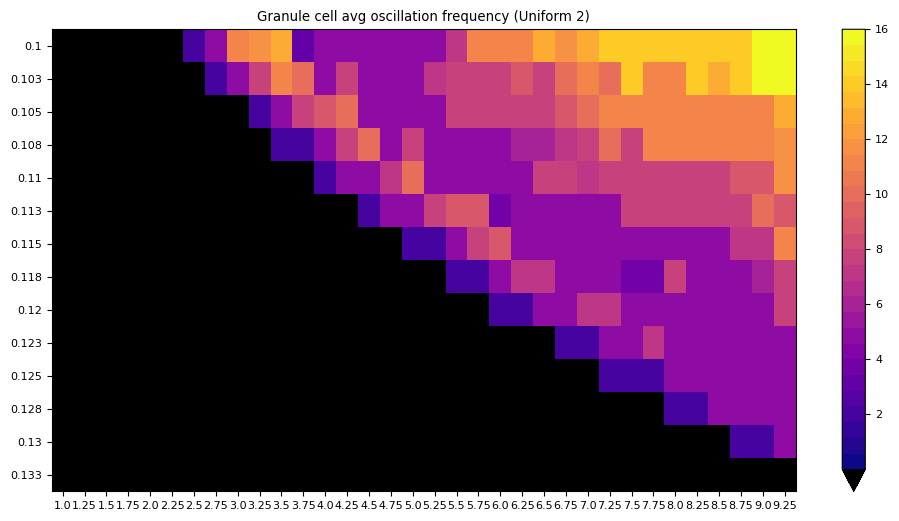

In [460]:
plot_heatmap(M_max_vals/10, 'Mitral cell max oscillation', 'M_max')
plot_heatmap(M_freq_vals, 'Mitral cell avg oscillation frequency', 'M_freq')
plot_heatmap(G_max_vals/10, 'Granule cell max oscillation', 'G_max')
plot_heatmap(G_freq_vals, 'Granule cell avg oscillation frequency', 'G_freq')